# General Index Unit Test
Small scale testing of general index data & processing

---
Created 6/3/22 by Ian Hay

In [ ]:
# To Do
#
# - add performance testing for functions
#   - make a testing function
#   - run for other functions necessary to build data
# - add LDA to pull out topics
#   - use nouns and adjectives, pool partitions
#   - concatenate words from papers/hashes, run as document
# - figure out other ways to visualize data
#   - color code by partition
#   - make edge weights dependent on numSimilar or Yake scoring
#   - add LDA labels to graph (with top keywords?)
# - make graphs prettier
#   - D3.js library
# - optimize functions for full General Index data processing
#   - figure out benchmarks to make processing feasible
#   - optimize bottlenecks
# - connect to SQL databases
# - think of other cool things to do (within the realm of DeSci)
#   - peer review relevancy
#   - automatic metadata curation

### Imports

In [23]:
from time import time
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from timeit import Timer
from pyvis.network import Network
from netgraph import Graph # https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

### Functions

In [57]:
# Utility

def loadTextFileIntoDataframe(filepath, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame()
    for line in data:
        lineSplit = line.split(splittingChar)
        df = df.append([lineSplit])
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """
    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column]
    The object in  df[column]  must be a list of strings
    """
    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" "))
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df[newColumnName].iloc[row] = string_list
    return df


# performance building adjMatrix on combined test set:
# * time for 100 iterations:  430.5321 seconds
# *     time per iteration: 4.305321 seconds
#
# *: timed on 16-thread CPU
def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix represents the number of alike elements.
    The object in  df[column]  must be a list of values.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            adjMatrix[n1][n2] = numSimilar
            if n1 == n2:
                adjMatrix[n1][n2] = 0 # removes recursive edges
            if numSimilar == 1:
                adjMatrix[n1][n2] = 0 # removes edges with 1 similarity to reduce complexity
    return adjMatrix

def visualizeNetwork(graph, filename, partitions=None):
    """
    Given a network as a Networkx Graph, saves an image to the given filepath
    and displays the network, both handled with Matplotlib.
    Utilizes NetworkX to build the network from the adjacency matrix.
    """

    community_generator = nx.algorithms.community
    partition = community_generator.louvain_partitions(graph)
    
    size = float(len(list(partition)))
    pos = nx.spring_layout(G)
    plt.figure(1, figsize=(24,24,), dpi=300.)

    count = 0.
    for com in set(partition) :
        count = count + 1.
        # color the nodes according to their partition
        cmap = cm.get_cmap('viridis', max(com) + 1) # this is not working as expected
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        n = nx.draw_networkx_nodes(graph, pos, list_nodes, node_size = 20, cmap=cmap, 
                                    node_color = str(count / size))

    e = nx.draw_networkx_edges(graph,pos, alpha=0.5)

    plt.savefig(filename)
    plt.show()

def visualizeNetworkHTML(adjMatrix, filename):
    """
    Given an adjacency matrix and the filename to save to, builds an HTML
    graph of that network.
    Uses pyvis to build an interactive HTML graph of a network from its adjacency matrix.
    Uses NetworkX to work with adjacency matrix.
    """
    G = nx.from_numpy_matrix(adjMatrix)
    net = Network(width="1920px", height="1080px", notebook=True)
    net.barnes_hut()
    net.from_nx(G)
    net.show(filename)

def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### Building Dataframe

In [9]:
# hard coded things
columnDict = {0: "hash", 1: "ngram", 2: "ngram_lc", 3: "ngram_num_tokens", 4: "ngram_count", 5: "term_freq", 6: "doc_count"}
non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

In [10]:
filenameAnte = "Test/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennig = "Test/doc_ngrams/sample.fgrep.Hennig86.txt"

df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnte)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennig)
df = pd.concat([df_antedivulian, df_hennig])
df.drop(7, axis=1, inplace=True)
df.rename(columns=columnDict, inplace=True)
df = df.groupby("hash").agg(list)

df = getUniqueWordsColumn(df, "ngram_lc", "ngram_words", nonWords=non_words)
df.head()

,ngram,ngram_lc,ngram_num_tokens,ngram_count,term_freq,doc_count,ngram_words
hash,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]","[0.0000097323600973236, 0.0000097323600973236]","[1, 1]","[antediluvian, humanity]"
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]","[0.00028050490883590464, 0.0002805049088359046...","[1, 1, 1, 1]","[antediluvian, follow, refrain]"
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]","[0.00009109127345600292, 0.0000910912734560029...","[1, 1, 1, 1, 1]","[antediluvian, dream, cave, mammoth]"
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]","[0.00019790223629527012, 0.0001979022362952701...","[1, 1, 1, 1]","[routine, hennig86, program]"
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],[0.00005075111652456354],[1],[antediluvian]


### Performance Testing

In [5]:
# t = Timer("buildAdjacencyMatrixByColumn(df, \"ngram_words\")", "from __main__ import buildAdjacencyMatrixByColumn, df")
# t.timeit(number=100)

KeyboardInterrupt: 

### ML

done in 2.493s.


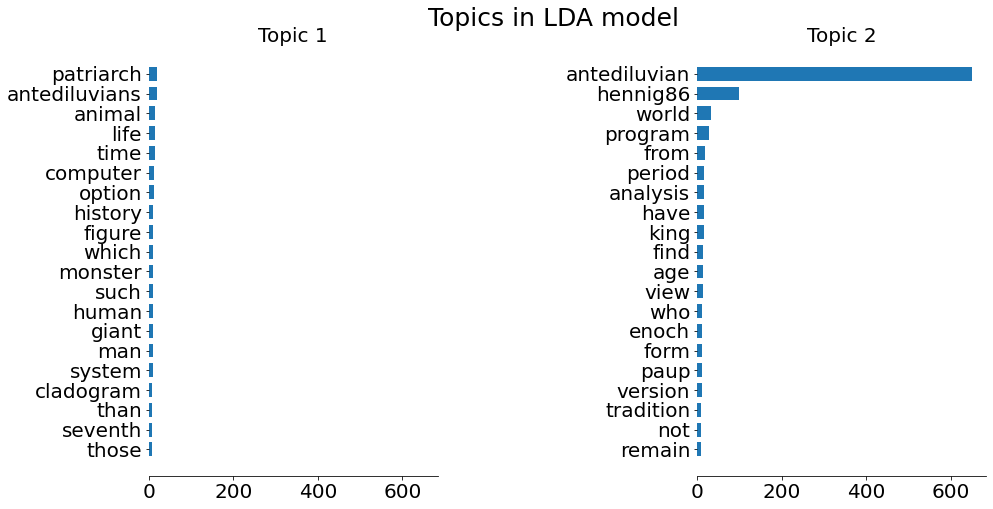

In [11]:
# on the whole data
vectorizer = CountVectorizer()
n_topics = 2
lda = LDA(n_components=n_topics)

doc = []
for hash in df.index:
    hashDoc = df.loc[hash]["ngram_words"]
    doc.append(hashDoc)
doc = list(itertools.chain(*doc)) # concatenates nested list into 1D list
X = vectorizer.fit_transform(doc).toarray() # sparse matrix of token counts
t0 = time()
lda.fit(X)
print("done in %0.3fs." % (time() - t0))
cols = vectorizer.get_feature_names_out()
plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model")

Building Louvain Partitions...
Done in 0.000s.

Building Label Propogation Partitions...
Done in 0.000s.

Fitting louvain data...
Done in 1.039s.


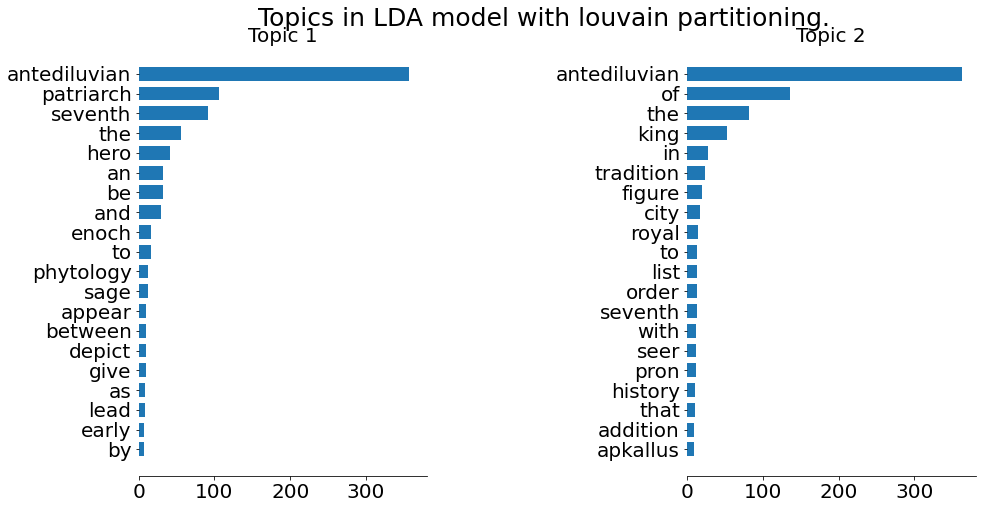


Fitting louvain data...
Done in 0.800s.


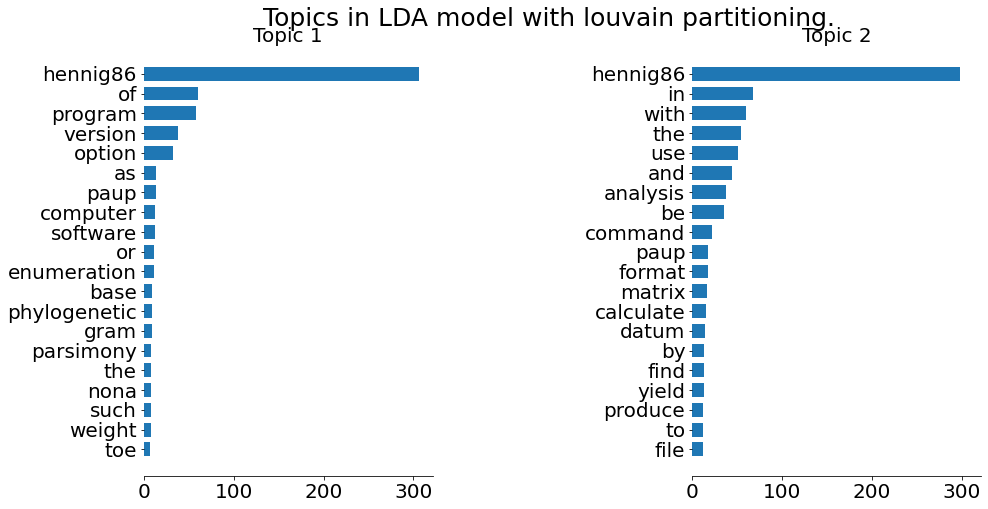

TypeError: object of type 'int' has no len()

In [18]:
# on partitions of data

adjMatrix = buildAdjacencyMatrixByColumn(df, "ngram_words")
G = nx.from_numpy_matrix(adjMatrix)
community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
louvainPartition = community_generator.louvain_partitions(G)
print("Done in %0.3fs." % (time() - t0))

# O(n^4) runtime
# print("\nBuilding Modularity Partitions...")
# t0 = time()
# modularityPartition = community_generator.naive_greedy_modularity_communities(G)
# print("Done in %0.3fs." % (time() - t0))

print("\nBuilding Label Propogation Partitions...")
t0 = time()
labelPropogationPartition = community_generator.asyn_lpa_communities(G)
print("Done in %0.3fs." % (time() - t0))

partitionDict = {"louvain": louvainPartition, "label propogation": labelPropogationPartition}
for partitionLabel in partitionDict.keys():
    
    indexList = []
    vectorizer = CountVectorizer()
    n_topics = 2
    lda = LDA(n_components=n_topics)
    
    partition = partitionDict.get(partitionLabel)
    partitionList = list(partition)
    partition = partitionList[0] # not sure why this is necesary

    for set in partition:
        if set is int:
            continue
        if len(set) > 80: # arbitrary cutoff, consider using the top X percent of communities by size
            indexList.append(set) # append all communities with more than 80 nodes

    for community in indexList:
        communityList = list(community)
        communityDoc = []
        for hash in communityList:
            hashDoc = df["ngram_lc"].iloc[hash]
            communityDoc.append(hashDoc)
        communityDoc = list(itertools.chain(*communityDoc)) # concatenates nested list into 1D list
        X = vectorizer.fit_transform(communityDoc).toarray() # sparse matrix of token counts
        
        print("\nFitting " + partitionLabel + " data...")
        t0 = time()
        lda.fit(X)
        print("Done in %0.3fs." % (time() - t0))
        cols = vectorizer.get_feature_names_out()
        plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model with " + partitionLabel + " partitioning.")

In [ ]:
partition = partitionList[0]
indexList = []
vectorizer = CountVectorizer()
n_topics = 2
lda = LDA(n_components=n_topics)

for set in partition:
    if len(set) > 80: # arbitrary cutoff, consider using the top X percent of communities by size
        indexList.append(set) # append all communities with more than 10 nodes

for community in indexList:
    communityList = list(community)
    communityDoc = []
    for hash in communityList:
        hashDoc = df["ngram_lc"].iloc[hash]
        communityDoc.append(hashDoc)
    communityDoc = list(itertools.chain(*communityDoc)) # concatenates nested list into 1D list
    X = vectorizer.fit_transform(communityDoc).toarray() # sparse matrix of token counts
    t0 = time()
    lda.fit(X)
    print("done in %0.3fs." % (time() - t0))
    cols = vectorizer.get_feature_names_out()
    plot_top_words(lda, cols, n_top_words=20, title="Topics in LDA model")

### Visualizations

In [47]:
adjmatrix = buildAdjacencyMatrixByColumn(df, "ngram_words")
G = nx.from_numpy_array(adjMatrix)

community_generator = nx.algorithms.community

print("Building Louvain Partitions...")
t0 = time()
community_sets = community_generator.louvain_communities(G, resolution=0.1)
print("Done in %0.3fs." % (time() - t0))

Building Louvain Partitions...
Done in 0.061s.


In [48]:
count = 0
node_to_community = {}
for set in community_sets:
    for x in set:
        node_to_community[x] = count
    count = count + 1

In [53]:
N = len(node_to_community.keys())
colorMap = plt.cm.viridis(np.linspace(0,1,N))
community_to_color = {}

for n in range(N):
    community_to_color[n] = colorMap[n]

In [55]:
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
)
plt.show()

c:\Users\ianha\anaconda3\lib\site-packages\netgraph\_node_layout.py:1152: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")


KeyboardInterrupt: 

In [58]:
cols_to_try = ["ngram_lc", "ngram_words"]
filename = "network_graph_"
for col in cols_to_try:
    adjmatrix = buildAdjacencyMatrixByColumn(df, col)
    G = nx.from_numpy_array(adjMatrix)
    visualizeNetwork(graph=G, filename=filename+col+".jpg")

TypeError: 'set' object is not callable

<Figure size 7200x7200 with 0 Axes>

In [ ]:
visualizeNetworkHTML(adjMatrix=buildAdjacencyMatrixByColumn(df, "ngram_words"), filename="HTML_graph_ngram_words_pooled_test_data.html")